In [ ]:
from sqldb import QueryDB

In [3]:
db = QueryDB()

1. Transaction Volume Over Time

In [4]:
qry = """
SELECT strftime('%Y', POSTED_DATE) AS year, COUNT(*) AS transaction_count, ACCOUNT_TYPE
FROM TRAn
GROUP BY year,ACCOUNT_TYPE
ORDER BY year,ACCOUNT_TYPE;
"""
db.execute(qry)

,year,transaction_count,ACCOUNT_TYPE
0,2021,1,CD
1,2021,18006,Checking
2,2021,208,Loan
3,2021,321,Savings
4,2022,8,CD
5,2022,32720,Checking
6,2022,380,Loan
7,2022,605,Savings
8,2023,8,CD
9,2023,35781,Checking


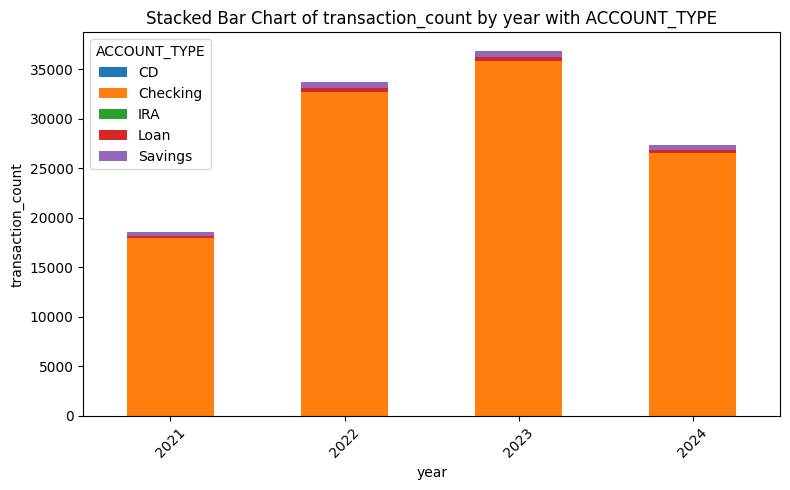

In [5]:
db.plot_stacked_bar(qry, "year", "transaction_count", "ACCOUNT_TYPE")

The data shows overall growth in transactions for checking and savings accounts from 2021 to 2024, suggesting a positive trend in customer engagement.

ENGAGEMENT SCORE

In [6]:
qry = """
SELECT 
    CUSTOMER_ID,
    COUNT(*) AS transaction_count,
    COALESCE(SUM(TRANSACTION_AMOUNT), 0) AS total_amount,
    (COUNT(*) * 0.5 + COALESCE(SUM(TRANSACTION_AMOUNT), 0) * 0.5) AS engagement_score
FROM 
    TRAN
GROUP BY 
    CUSTOMER_ID
HAVING 
    COUNT(*) > 0
ORDER BY 
    engagement_score DESC
LIMIT 10;
"""
db.execute(qry)

,CUSTOMER_ID,transaction_count,total_amount,engagement_score
0,9817178,3,48446630.16,2.422332e+07
1,6059066,3,44921764.99,2.246088e+07
2,8325927,4,36245303.44,1.812265e+07
3,4199470,1,25068811.91,1.253441e+07
4,9997760,5,20013809.98,1.000691e+07
5,1561357,3,14631934.09,7.315969e+06
6,8069717,1,13182000.51,6.591001e+06
7,116624,1,10871465.89,5.435733e+06
8,31741169,1,8400000.00,4.200000e+06
9,33131851,5,7970742.53,3.985374e+06


Customers like 9817178 and 6059066 are top spenders with multiple transactions, indicating strong engagement

In [7]:
CUSTOMER SEGMENTATION

SyntaxError: invalid syntax (1559139626.py, line 1)

In [ ]:
qry = """
SELECT segment, COUNT(CUSTOMER_ID) AS customer_count
FROM (
    SELECT CUSTOMER_ID,
           CASE 
               WHEN SUM(TRANSACTION_AMOUNT) > 1000 THEN 'High Spender'
               WHEN COUNT(*) > 20 THEN 'Frequent Shopper'
               ELSE 'Occasional User'
           END AS segment
    FROM TRAN
    GROUP BY CUSTOMER_ID
) AS segments
GROUP BY segment;
"""
db.execute(qry)

the majority of customers are occasional users, with a large subset also considered high spenders. This insight can help in tailoring marketing strategies for different customer segments.

In [ ]:
db.plot(qry,"segment","customer_count", "pie")

ANAMOLY Detection: Large Transactions

In [ ]:
qry = """
WITH transaction_stats AS (
    SELECT 
        AVG(TRANSACTION_AMOUNT) AS avg_amount,
        (SUM(TRANSACTION_AMOUNT * TRANSACTION_AMOUNT) / COUNT(*) - 
         (AVG(TRANSACTION_AMOUNT) * AVG(TRANSACTION_AMOUNT))) AS variance
    FROM TRAN
)
SELECT 
    CUSTOMER_ID,
    ACCOUNT_ID,
    account_type,
    TRANSACTION_ID,
    TRANSACTION_AMOUNT,
    EXTERNAL_CATEGORY,
    strftime('%Y-%m', POSTED_DATE) AS posted_month
FROM TRAN, transaction_stats
WHERE TRANSACTION_AMOUNT > (avg_amount + 3 * SQRT(variance));
"""
db.execute(qry)

it identifies transactions that exceed a certain threshold—typically defined as being more than three standard deviations above the average transaction amount.Potential Anomalies: If the output was filtered for anomalies, these transactions are likely outliers, suggesting that they are larger than average or unusual in some other way based on your statistical calculations.

In [ ]:
db.plot_stacked_bar(qry, "posted_month", "TRANSACTION_AMOUNT", "ACCOUNT_TYPE")

Spending Pattern Analysis

In [ ]:
qry = """
WITH Monthly_Spending AS (
    SELECT 
        strftime('%Y-%m', POSTED_DATE) AS month,
        ACCOUNT_TYPE,
        SUM(TRANSACTION_AMOUNT) AS total_spent,
        COUNT(*) AS transaction_count
    FROM TRAN
    WHERE TRANSACTION_AMOUNT < 0  -- Assuming negative values represent spending
    GROUP BY month, ACCOUNT_TYPE
),


Overall_Spending AS (
    SELECT 
        ACCOUNT_TYPE,
        SUM(TRANSACTION_AMOUNT) AS total_spent,
        COUNT(*) AS transaction_count
    FROM TRAN
    WHERE TRANSACTION_AMOUNT < 0
    GROUP BY ACCOUNT_TYPE
)

SELECT 
    'Monthly Analysis' AS analysis_type,
    month,
    ACCOUNT_TYPE,
    total_spent,
    transaction_count
FROM Monthly_Spending
UNION ALL

SELECT 
    'Overall Analysis' AS analysis_type,
    NULL AS month_or_year,
    ACCOUNT_TYPE,
    total_spent,
    transaction_count
FROM Overall_Spending
ORDER BY analysis_type, month_or_year, ACCOUNT_TYPE
;
"""
db.execute(qry)

In [ ]:
db.plot_stacked_bar(qry,"analysis_type","transaction_count", "ACCOUNT_TYPE")

In [ ]:
qry = """
with Yearly_Spending AS (
    SELECT 
        strftime('%Y', POSTED_DATE) AS year,
        ACCOUNT_TYPE,
        SUM(TRANSACTION_AMOUNT) AS total_spent,
        COUNT(*) AS transaction_count
    FROM TRAN
    WHERE TRANSACTION_AMOUNT < 0
    GROUP BY year, ACCOUNT_TYPE
)

SELECT 
    'Yearly Analysis' AS analysis_type,
    year,
    ACCOUNT_TYPE,
    total_spent,
    transaction_count
FROM Yearly_Spending;
"""
db.execute(qry)

The Checking account consistently shows the highest total spending across all years, especially in 2022, which stands out with over $24 million spent

In [ ]:
db.plot(qry,"year", "transaction_count", "line")

JOINING TWO TABLES

Inactive customers from the Customer Table from the given data

In [ ]:
qry = """
SELECT 
    I.CUSTOMER_ID,
    I.CUSTOMER_JOIN_DATE,
    I.LAST_LOGIN_DATE
FROM 
    INFO I
LEFT JOIN 
    TRAN T ON I.CUSTOMER_ID = T.CUSTOMER_ID
GROUP BY 
    I.CUSTOMER_ID
HAVING 
    COUNT(T.TRANSACTION_ID) = 0 OR 
    MAX(T.POSTED_DATE) < DATE('now', '-1 year');
"""
db.execute(qry)

 State-wise Spending Analysis

In [ ]:
qry = """
SELECT 
    I.STATE,
    SUM(T.TRANSACTION_AMOUNT) AS TOTAL_SPENDING,
    COUNT(DISTINCT I.CUSTOMER_ID) AS NUMBER_OF_CUSTOMERS
FROM 
    INFO I
LEFT JOIN 
    TRAN T ON I.CUSTOMER_ID = T.CUSTOMER_ID
GROUP BY 
    I.STATE
ORDER BY 
    TOTAL_SPENDING DESC
"""
db.execute(qry)

In [ ]:
qry = """
SELECT 
    CUSTOMER_TYPE,
    CUSTOMER_SEGMENT,
    COUNT(DISTINCT CUSTOMER_ID) AS NUMBER_OF_CUSTOMERS
FROM (
    SELECT 
        I.CUSTOMER_ID,
        I.CUSTOMER_TYPE,
        SUM(T.TRANSACTION_AMOUNT) AS TOTAL_SPENT,
        CASE 
            WHEN SUM(T.TRANSACTION_AMOUNT) >= 1000 THEN 'High Value'
            WHEN SUM(T.TRANSACTION_AMOUNT) BETWEEN 500 AND 999 THEN 'Medium Value'
            ELSE 'Low Value'
        END AS CUSTOMER_SEGMENT
    FROM 
        INFO I
    LEFT JOIN 
        TRAN T ON I.CUSTOMER_ID = T.CUSTOMER_ID
    GROUP BY 
        I.CUSTOMER_ID, I.CUSTOMER_TYPE
) AS Subquery
GROUP BY 
    CUSTOMER_TYPE, CUSTOMER_SEGMENT
ORDER BY 
    CUSTOMER_TYPE, CUSTOMER_SEGMENT;
"""
db.execute(qry)

In [ ]:
db.plot_stacked_bar(qry,"CUSTOMER_SEGMENT", "NUMBER_OF_CUSTOMERS","CUSTOMER_TYPE" )